In [1]:
# source code inspireed by
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

# show plot first run
%matplotlib inline 
# test autocompletion with tab or tab+shift
%config IPCompleter.greedy=True 

#vgg26 Inspiration
<img src="data/vgg16-1-e1542731207177.png">

In [17]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

use_cuda = torch.cuda.is_available()
print('cuda_available:',use_cuda)

root = './data'

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

print('Loading dataset')
train_set = datasets.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_set = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
print('Datasets loaded')

# hyperparameter
# TODO Find good hyperparameters
batch_size = 4
num_epochs = 5
learning_rate = 0.001
momentum = 0.9

# Load train and test data as dictionary!!!
data_loaders = {}
data_loaders['train'] = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
data_loaders['test'] = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)


# implement your own NNs

class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        # TODO YOUR CODE HERE
        #https://neurohive.io/en/popular-networks/vgg16/
        #input size=1x28x28
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5,stride=1)
        #conv1: 28x28x1 -> 24x24x64
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5,stride=1)
        self.drop = nn.Dropout(0.25)
        #conv2: 24x24x16 -> 20x20x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,stride=1)
        #conv3: 20x20x64 -> 18x18x64
        #pooling: 18x18x64 -> 9x9x64
        self.fc1   = nn.Linear(9*9*64, 2048)
        self.fc2   = nn.Linear(2048, 512)
        self.fc3   = nn.Linear(512, 10)
    def forward(self, x):
        # TODO YOUR CODE HERE
        conv1_relu = F.relu(self.conv1(x))                          #conv1: 28x28x1 -> 24x24x64
        x = self.drop(x)
        conv2_relu = F.relu(self.conv2(conv1_relu))                 #conv2: 24x24x64 -> 20x20x128
        conv3_relu = F.max_pool2d(F.relu(self.conv3(conv2_relu)),2) #conv3: 20x20x128 -> 16x16x256
        x = self.drop(x)                                            #pooling: 16x16x256 -> 8x8x256  
        x = conv3_relu.view(-1, 9*9*64)                             # fc 8*8*256, 4096
        x = F.relu(self.fc1(x))                                     # fc 4096, 1000
        x = F.relu(self.fc2(x))                                     # fc 1000, 10
        x = F.softmax(self.fc3(x),dim=1)                                             # fc 10 out
        return x
    
    def name(self):
        return "MyNeuralNetwork"

## training
model = MyNeuralNetwork()
print(model)




PyTorch Version:  1.3.1
Torchvision Version:  0.4.2
cuda_available: True
Loading dataset
Datasets loaded
MyNeuralNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [18]:
# read nn model
#PATH = './bak-'+ model.name() +'.pth'
#model.load_state_dict(torch.load(PATH))

In [19]:
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_acc_history = []
test_acc_history = []

train_loss_history = []
test_loss_history = []


best_acc = 0.0
since = time.time()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(data_loaders[phase]):
            # zero the parameter gradients
            optimizer.zero_grad()
            
            #print(labels.shape)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                #print('in',inputs.shape)
                #print('out',outputs.shape)
                #print('labels',labels.shape)
                outputs.reshape(-1)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if batch_idx % 500 == 0:
                print('{} Batch: {} of {}'.format(phase, batch_idx, len(data_loaders[phase])))
                
            #if batch_idx == 2000:
            #    break
                

        epoch_loss = running_loss / len(data_loaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(data_loaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'test':
            test_acc_history.append(epoch_acc)
            test_loss_history.append(epoch_loss)
        if phase == 'train':
            train_acc_history.append(epoch_acc)
            train_loss_history.append(epoch_loss)

    #print()

Epoch 0/4
----------
train Batch: 0 of 15000
train Batch: 500 of 15000
train Batch: 1000 of 15000
train Batch: 1500 of 15000
train Batch: 2000 of 15000
train Batch: 2500 of 15000
train Batch: 3000 of 15000
train Batch: 3500 of 15000
train Batch: 4000 of 15000
train Batch: 4500 of 15000
train Batch: 5000 of 15000
train Batch: 5500 of 15000
train Batch: 6000 of 15000
train Batch: 6500 of 15000
train Batch: 7000 of 15000
train Batch: 7500 of 15000
train Batch: 8000 of 15000
train Batch: 8500 of 15000
train Batch: 9000 of 15000
train Batch: 9500 of 15000
train Batch: 10000 of 15000
train Batch: 10500 of 15000
train Batch: 11000 of 15000
train Batch: 11500 of 15000
train Batch: 12000 of 15000
train Batch: 12500 of 15000
train Batch: 13000 of 15000
train Batch: 13500 of 15000
train Batch: 14000 of 15000
train Batch: 14500 of 15000
train Loss: 2.0231 Acc: 0.4354
test Batch: 0 of 2500
test Batch: 500 of 2500
test Batch: 1000 of 2500
test Batch: 1500 of 2500
test Batch: 2000 of 2500
test Loss: 

In [20]:
# save model
#print('Saving model',PATH)
#torch.save(model.state_dict(), PATH)

Training complete in 136m 44s
Best val Acc: 0.829300


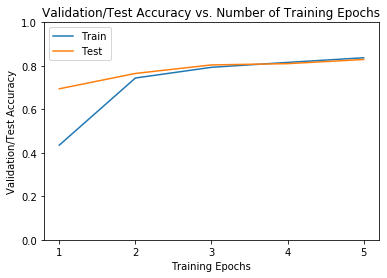

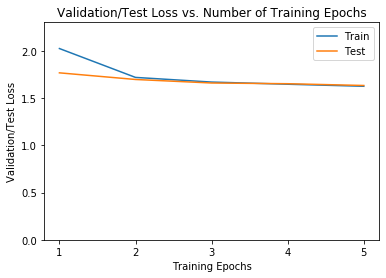

IndexError: index 4 is out of bounds for dimension 0 with size 4

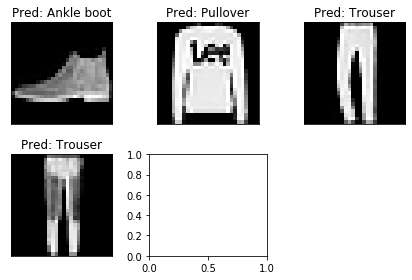

In [21]:
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

acc_train_hist = []
acc_test_hist = []

acc_train_hist = [h.cpu().numpy() for h in train_acc_history]
acc_test_hist = [h.cpu().numpy() for h in test_acc_history]

plt.title("Validation/Test Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation/Test Accuracy")
plt.plot(range(1,num_epochs+1),acc_train_hist,label="Train")
plt.plot(range(1,num_epochs+1),acc_test_hist,label="Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.savefig('ex3_3_acc_vgg16.png')
plt.show()

#print(np.arange(1,num_epochs+1),train_loss_history)
#print(np.arange(1,num_epochs+1),test_loss_history)

plt.title("Validation/Test Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation/Test Loss")
plt.plot(range(1,num_epochs+1),train_loss_history,label="Train")
plt.plot(range(1,num_epochs+1),test_loss_history,label="Test")
plt.ylim((0,2.3))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.savefig('ex3_3_loss_vgg16.png')
plt.show()


examples = enumerate(data_loaders['test'])
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = model(example_data)

categories = {
    0:	'T-shirt/top',
    1:	'Trouser',
    2:	'Pullover',
    3:	'Dress',
    4:	'Coat',
    5:	'Sandal',
    6:	'Shirt',
    7:	'Sneaker',
    8:	'Bag',
    9:	'Ankle boot'
}

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Pred: {}".format(
      categories[output.data.max(1, keepdim=True)[1][i].item()]))
  plt.xticks([])
  plt.yticks([])
plt.show()

